# Galaxy Selector MOC

**Designed to work with Multi-Ordering-Sky-Maps and both burst (i.e. no distance) and normal LVK maps**



Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 99% credible regions for the event, add them as a column to the data
- only keep data within the 99% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

(some) Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc
from scipy.integrate import quad


from astropy.io import fits, ascii
from astropy.table import Table, hstack, QTable
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

import astropy_healpix as ah


import psycopg2

from scipy.stats import norm

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import requests as rq

import gasel as gs

from datetime import datetime
from datetime import timedelta
from datetime import date
from suntimes import SunTimes
import pytz

In [2]:
# Get DESI data
print("(to get DESI data) you should run scp dgruen@perlmutter.nersc.gov:/pscratch/sd/j/jgassert/good_z_data.fits /project/ls-gruen/ligodesi/")

# specify the superevent name:
superevent_name = "S230619bg"

# pipeline - bayestar is preferred if available, otherwise maybe use olib? bilby? cwb? whatever these mean
pipeline_type = "bayestar"

if pipeline_type == "cwb":
    # bursts probably only for very nearby core-collapse or Andromeda events, maybe cut at 1Mpc or something of that order? -> check if there is a very nearby galaxy
        # think about which pipeline detected it!
    # or very massive bbh but then hope is that cbc would detect as well
    
    modeled_search = False
else:
    modeled_search = True

# storage directory
# storage = "/project/ls-gruen/ligodesi/"
# storage_desi_data = storage
storage = "/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/" # Julius on NERSC
storage_desi_data = "/pscratch/sd/j/jgassert/"

(to get DESI data) you should run scp dgruen@perlmutter.nersc.gov:/pscratch/sd/j/jgassert/good_z_data.fits /project/ls-gruen/ligodesi/


In [5]:
path = storage+f"{superevent_name}{pipeline_type}.multiorder.fits,1" # 5min after alert this should be there

try:
    skymap = QTable.read(path)
    print("read skymap from local file")
    
except:
    download_url = f"https://gracedb.ligo.org/api/superevents/{superevent_name}/files/{pipeline_type}.multiorder.fits,1"
    save_path = storage+f"{superevent_name}{pipeline_type}.multiorder.fits,1"
    print("no local skymap...")
    print(f"...will download LIGO event file from superevent {superevent_name}, corresponding file URL is {download_url} and save it in .../Files/")
    
    response = rq.get(download_url, allow_redirects = True)
    print("HTTP status",response.status_code)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
            
        skymap = QTable.read(path)

no local skymap...
...will download LIGO event file from superevent S230619bg, corresponding file URL is https://gracedb.ligo.org/api/superevents/S230619bg/files/bayestar.multiorder.fits,1 and save it in .../Files/
HTTP status 200


Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [6]:
skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,1.1848687265984231e-07,31.606211061353385,157.26184435555413,5.932038732751096e-05
1025,1.2661026595950913e-07,-210.63809144678473,193.95076343968125,0.0004278928007618939
1026,1.0662937832413237e-07,70.39447572563797,151.69033338438769,4.384969951055856e-05
1027,1.1742445420135443e-07,-148.50859514919424,186.45424850201562,0.0002468273821382713
1028,1.586867953201177e-07,-1022.2560517210268,282.9580490334632,0.7204030905016724


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [7]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  367551


In [8]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  114.91416309012875 46.3750811884355 with prob [1/deg^2] of:  0.0011024695368083816 and UNIQ ID:  367551


Now open the fits file and read basics info from the header

In [9]:
if modeled_search:
    fits_gw = fits.open(path)
    header = fits_gw[1].header
    dist_mean = header["DISTMEAN"]
    dist_std = header["DISTSTD"]
    print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)
    most_likely_z = z_at_value(Planck18.luminosity_distance, dist_mean*u.Mpc, zmax = 5)
    most_likely_z_std = z_at_value(Planck18.luminosity_distance, dist_std*u.Mpc, zmax = 5)
    print(f"This corresponds to the most likely z {most_likely_z} and its error {most_likely_z_std}")
else:
    print("As this is an unmodeled search there is no distance available")

The dist_mean and dist_std values:  174.9921172475915 Mpc 56.39367956242045 Mpc
This corresponds to the most likely z 0.03838040911111858 redshift and its error 0.012606192749614376 redshift


### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [106]:
follow_up_others = True

follow_up_their_z = False

In [184]:
if follow_up_others:
    center_ra = 109.25
    center_dec = 63.68
    radius = 1.227
    
    data = gs.db_doall(center_ra, center_dec, radius)
    
    if follow_up_their_z:
        z_others = 0
        z_others_std = 0.4
        sigma_accuracy = 1
    
        ii = data["Z"]-sigma_accuracy*data["ZERR"]<z_others+sigma_accuracy*z_others_std
        ii &= data["Z"]+sigma_accuracy*data["ZERR"]>z_others-sigma_accuracy*z_others_std
    
        data = data[ii]
    
    
else:
    data = Table.read(storage_desi_data+"good_z_data.fits")

In [185]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64
2390768907976704,108.117557695096,63.3898431837045,20221205,0.040290694709979,1.41089692161923e-05,0,0.0,0.0,0.0,GALAXY,0,0.0678029283881187,0.0
2390768933142528,111.989797314532,63.6146358407325,20211117,0.0934443871117946,1.90568192578149e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
2390774276685824,106.902575002915,64.1112227574243,20221205,0.0660483607657598,3.56884559173764e-06,0,0.0,0.0,0.0,GALAXY,0,0.0419820547103882,0.0
2390776952651779,108.902911335767,64.3218075418946,20221205,0.0369128515434421,2.16750059284245e-05,0,0.0,0.0,0.0,GALAXY,0,0.0644607543945312,0.0
2390779574091786,107.213934346044,64.4718658628562,20221205,0.0368722464794676,2.59529363438167e-05,0,0.0,0.0,0.0,GALAXY,0,0.0424562469124794,0.0


## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of r-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 99% credible region (i.e. with a certainty of 99% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [186]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64
2390768907976704,108.117557695096,63.3898431837045,20221205,0.040290694709979,1.41089692161923e-05,0,0.0,0.0,0.0,GALAXY,0,0.0678029283881187,0.0
2390768933142528,111.989797314532,63.6146358407325,20211117,0.0934443871117946,1.90568192578149e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
2390774276685824,106.902575002915,64.1112227574243,20221205,0.0660483607657598,3.56884559173764e-06,0,0.0,0.0,0.0,GALAXY,0,0.0419820547103882,0.0
2390776952651779,108.902911335767,64.3218075418946,20221205,0.0369128515434421,2.16750059284245e-05,0,0.0,0.0,0.0,GALAXY,0,0.0644607543945312,0.0
2390779574091786,107.213934346044,64.4718658628562,20221205,0.0368722464794676,2.59529363438167e-05,0,0.0,0.0,0.0,GALAXY,0,0.0424562469124794,0.0


### data clean up

In [187]:
#data = data[data["Z"]> 0] # this migh have 2 reasons
#data = data[data["ZWARN"] == 0]

In [188]:
#data = data[data['FLUX_Z']>0]
# data = table.unique(data, keys = "TARGETID")

In [189]:
data = data[data["TARGETID"]>0]

In [190]:
print(f"We have {len(data)} objects in the full catalog")

We have 5694 objects in the full catalog


We should also get rid of stars, since they wont be the host of a GW event

In [191]:
data = data[data["SPECTYPE"] != "STAR"]

### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [192]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

if modeled_search:
    distmu = skymap[sorter_i]["DISTMU"]
    distsigma = skymap[sorter_i]["DISTSIGMA"]
    distnorm = skymap[sorter_i]["DISTNORM"]


In [193]:
# len(UNIQ), len(data), len(skymap)

In [194]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [195]:
if modeled_search:
    data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])
else: 
    data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity})])
    print(f"The table will not contain any distance info since there is none available")

In [196]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
2390768907976704,108.117557695096,63.3898431837045,20221205,0.040290694709979,1.41089692161923e-05,0,0.0,0.0,0.0,GALAXY,0,0.0678029283881187,0.0,96790,0.0006250125158475294,149.3033049375056,57.516043844177965,3.906753146601501e-05
2390768933142528,111.989797314532,63.6146358407325,20211117,0.0934443871117946,1.90568192578149e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,385959,0.0007781040677504851,151.48402115621033,57.97892255525045,3.801383409175562e-05
2390774276685824,106.902575002915,64.1112227574243,20221205,0.0660483607657598,3.56884559173764e-06,0,0.0,0.0,0.0,GALAXY,0,0.0419820547103882,0.0,96796,0.0005788118273295831,148.72895335352928,57.4337816536212,3.9345266769761104e-05
2390776952651779,108.902911335767,64.3218075418946,20221205,0.0369128515434421,2.16750059284245e-05,0,0.0,0.0,0.0,GALAXY,0,0.0644607543945312,0.0,96834,0.0006475363119740661,149.35125624822575,57.55771747081563,3.903839842271462e-05
2390779574091786,107.213934346044,64.4718658628562,20221205,0.0368722464794676,2.59529363438167e-05,0,0.0,0.0,0.0,GALAXY,0,0.0424562469124794,0.0,96797,0.0005907768266173125,148.75350937953618,57.453699574300764,3.9330431864940366e-05


In [197]:
print(f"The highest and lowest probability values in our catalog are: {np.max(probdensity)} and {np.min(probdensity)}")

The highest and lowest probability values in our catalog are: 0.0007976139821086394 and 0.0005333777673477411


### Sort the skymap table and get 99% credible region

In [198]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [199]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [200]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [201]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
367551,3.6191939961290607,153.67349325223066,57.556566405347546,3.7138720144593e-05
367595,3.618619872501153,154.0953614985823,57.71548913236724,3.6935504629802136e-05
367547,3.6168927557782644,153.24215649463997,57.39535664340765,3.734803144063708e-05
367594,3.616534301359978,154.03607733098687,57.69556994020809,3.6963582046791717e-05
373061,3.6157410492109827,154.27343879979674,57.78133019061871,3.6850418724867694e-05


In [202]:
# now get 99% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.99
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.99)

# print area
area_99 = pixel_area[:i].sum()
area_99_deg = area_99.to_value(u.deg**2)
print(f"The 99% search area is {area_99_deg}°large")

The 99% search area is 10343.45488358242°large


### can be deleted, just tried things out

In [203]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [204]:
np.max(prob)

<Quantity 0.00014055>

In [205]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
367551,3.6191939961290607,153.67349325223066,57.556566405347546,3.7138720144593e-05,5.783097976763582e-05
367595,3.618619872501153,154.0953614985823,57.71548913236724,3.6935504629802136e-05,5.782180586539538e-05
367547,3.6168927557782644,153.24215649463997,57.39535664340765,3.734803144063708e-05,5.779420832506885e-05
367594,3.616534301359978,154.03607733098687,57.69556994020809,3.6963582046791717e-05,5.7788480593912766e-05
373061,3.6157410492109827,154.27343879979674,57.78133019061871,3.6850418724867694e-05,5.777580524436581e-05


In [206]:
skymap_prob = Table(skymap_sort, copy = True)

In [207]:
skymap_prob.sort("PROB", reverse = True)

In [208]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
97050,2.1989773992715316,147.76688856287637,57.37270689511823,3.9803179208849764e-05,0.00014054954514488592
23539,0.5497211637150999,142.82143317866758,56.69579051758552,4.235716243793389e-05,0.00014054361730551673
90209,2.1988311850416404,142.93113725805495,52.85200275871076,4.306450317692669e-05,0.00014054019973573723
90846,2.1986813615785503,136.68002397701574,51.866596314038766,4.6795590497600065e-05,0.00014053062363932243
12667,0.13738820136913166,76.06707060319594,53.42142148393927,0.00011680936842477672,0.00014050057425494113


### Compare Tables, only leave 99% credible region in DESI data table

Now we can get a Table that only contains the 99% credible region. From there we only leave the matching objects in the DESI data

In [209]:
# we simply select only the entries that are within the 99% credible region
skymap_99 = skymap_sort[:i]

In [210]:
print("This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_99["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 74


In [211]:
mask = np.in1d(data["UNIQ"], skymap_99["UNIQ"])
data_99 = data[mask]

In [212]:
print(f"We now have {len(data_99)} objects in the 99% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_99["TARGET_RA"]), np.max(data_99["TARGET_RA"]), np.min(data_99["TARGET_DEC"]), np.max(data_99["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_99["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 4962 objects in the 99% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  106.49777700661 112.009189774526 62.4584945523612 64.8976280734181
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is False


In [213]:
data_99.sort('PROBDENSITY', reverse=True)

In [214]:
data_99[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
39633426789174617,111.936857360301,63.4743674946783,20230129,0.379383738868246,4.07679684567819e-05,0,5.00664520263672,15.5178127288818,27.9241046905518,GALAXY,514,0.060694582760334,1.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05
39633426789174471,111.917533419385,63.4911023975644,20211117,0.131012387241451,1.08493925107933e-05,0,5.82465934753418,8.98613262176514,11.9544172286987,GALAXY,257,0.0608360022306442,1.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05


In [215]:
if modeled_search:
    print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
    min_z = np.min(data_99["Z"])
    max_z = np.max(data_99["Z"])
    print(f"However, we have not used the distance data at all. Therefore our redshifts range from {min_z} to {max_z}")
else:
    print(f"Usually we would be performing steps to cut out objects that don't meet the z-range/distance from LIGO, since there is no distance, we - at least for now include everything!")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redshifts range from 2.20487824533604e-06 to 3.30872397027335


### Calculate all the distances of the objects from the redshifts

We want to be conservative in estimating the distance from redshifts, therefore we will include different cosmologies.

Our cosmologies include:
- H0 = 68.20 ± 0.81 km s−1Mpc−1, from eBOSS https://arxiv.org/pdf/2007.08991.pdf
- DES Y3 https://arxiv.org/abs/2105.13549
- SH0ES https://pantheonplussh0es.github.io/

Now we calculate the arithmetic mean of our distances and its standard deviation:
$$distances_{mean} = \frac{dist(z_{cosmo_{max}})+dist(z_{cosmo_{min}})}{2}$$
and accordingly the standard deviation (n=2):
$$\sigma = \sqrt{\frac{1}{n-1}\sum\left(dist_i-distances_{mean}\right)^2}$$


In [216]:
#distances = Distance(z=data_99["Z"], cosmology=Planck18)
#distances_err = Distance(z=data_99["ZERR"], cosmology=Planck18)

In [217]:
if modeled_search:
    # first define the cosmological maximum and minimum parameters
    omega_M_max = 0.339+0.032 #(from DES)
    omega_M_min = 0.299-2*0.016 #from eBOSS

    H_0_max = 73.04+2*1.04 #from SH0ES
    H_0_min = 67.4-2*0.5 #from Planck
    
    # then calculate min and max luminosity distance from the redshifts
    cosmo_min_dist = FlatLambdaCDM(H0=H_0_max, Om0=omega_M_max)
    cosmo_max_dist = FlatLambdaCDM(H0=H_0_min, Om0=omega_M_min)

    dists_max = Distance(z=data_99["Z"], cosmology=cosmo_max_dist)
    dists_min = Distance(z=data_99["Z"], cosmology=cosmo_min_dist)
    
    # and of course also calculate the maximum and minimum error from the redshfit uncertainty
    dists_err_min = Distance(z=data_99["ZERR"], cosmology=cosmo_max_dist)
    dists_err_max = Distance(z=data_99["ZERR"], cosmology=cosmo_min_dist)
    
    # now we get the mean distance and its error
    dists_mean = (dists_max+dists_min)/2
    dists_err_mean = (dists_err_max+dists_err_min)/2  # this is our sigma for the redshift error
    
    # calculate the stdev of the distance depending on the cosmology
    dists_mean_stddev = np.sqrt((dists_max-dists_mean)**2+(dists_min-dists_mean)**2)
    
    # now stack all the data
    data_99 = hstack([data_99, Table({"DIST_Z_MEAN": dists_mean}), Table({"DIST_Z_ERR": dists_err_mean}), Table({"DIST_Z_COSMO_SIGMA": dists_mean_stddev})])

In [218]:
# dists_mean[:5], dists_mean_stddev[:5], dists_mean_stddev[:5]/dists_mean[:5], np.mean(dists_mean_stddev/dists_mean), np.max(dists_mean_stddev/dists_mean), np.min(dists_mean_stddev/dists_mean)


In [219]:
data_99[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39633426789174617,111.936857360301,63.4743674946783,20230129,0.379383738868246,4.07679684567819e-05,0,5.00664520263672,15.5178127288818,27.9241046905518,GALAXY,514,0.060694582760334,1.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05,2018.8579553017184,0.17338736646680636,215.3732396595541
39633426789174471,111.917533419385,63.4911023975644,20211117,0.131012387241451,1.08493925107933e-05,0,5.82465934753418,8.98613262176514,11.9544172286987,GALAXY,257,0.0608360022306442,1.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05,610.2495337872992,0.046141731299051816,57.51259125602893
39633426789175050,112.000075872904,63.5873232374804,20211021,0.156678985110412,3.62502954571809e-05,0,26.4139022827148,80.9213562011719,168.434906005859,GALAXY,514,0.0559299886226654,6.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05,741.5103435691892,0.15417303908936658,70.89107282734332
39633426789174819,111.96769974688,63.5252815916207,20211117,0.508485783245216,7.23605864838721e-05,0,1.61727976799011,7.71978330612183,24.2473335266113,GALAXY,257,0.0591009184718132,1.0,385957,0.0007976139821086394,151.85054126037488,58.04194675311499,3.784333889126021e-05,2856.667984400731,0.30775911760407515,321.07194775830806
39633426789174346,111.8961949227,63.4247827588558,20211021,0.356311702702702,9.38122175032557e-05,0,3.06520199775696,15.5115604400635,39.6922149658203,GALAXY,514,0.0640551969408989,4.0,385956,0.0007946236598688675,151.9264010963017,58.064455695839726,3.780662849277352e-05,1876.0298164025317,0.39900226463243077,198.11190284442992


### Lets check how much the distance measurement changes in the 99% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our LIGO distances range from -2854.2626133573617 Mpc to 212.31816013823467 Mpc
Let's visualize the distance distribution of the LIGO event in the 99% credible region


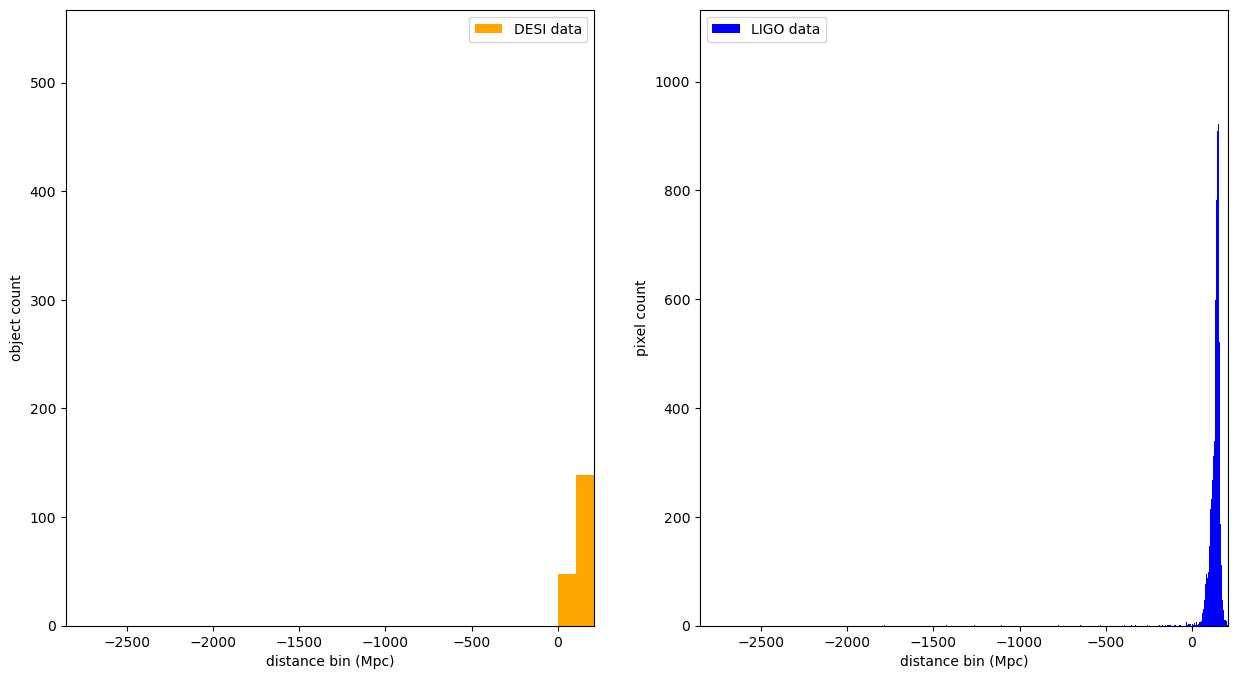

In [220]:
if modeled_search:
    plt_skymap = skymap_99[skymap_99["DISTMU"]<np.inf]

    dist_max_99 = np.max(plt_skymap["DISTMU"])*u.Mpc
    dist_min_99 = np.min(plt_skymap["DISTMU"])*u.Mpc
    print(f"Our LIGO distances range from {dist_min_99} to {dist_max_99}")
    print("Let's visualize the distance distribution of the LIGO event in the 99% credible region")

    fig, ax = plt.subplots(ncols = 2, figsize = (15,8))


    ax[0].hist(data_99["DIST_Z_MEAN"], bins = "auto", color = "orange", label = "DESI data")
    ax[1].hist(plt_skymap["DISTMU"], bins = "auto", color = "blue", label = "LIGO data")


    for axis in ax:
        axis.set_xlabel("distance bin (Mpc)")
        axis.set_xlim(dist_min_99/u.Mpc, dist_max_99/u.Mpc)
        axis.legend()

    ax[0].set_ylabel("object count")
    ax[1].set_ylabel("pixel count")

    plt.show()

In [221]:
len(skymap_99), len(data_99)

(16839, 4962)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

*Note: We do this only for our own GW-follow ups*

In [222]:
if follow_up_their_z == False and modeled_search == True:
    z_selection_mask = data_99["DIST_Z_MEAN"] - 2*data_99["DIST_Z_ERR"] - 2*data_99["DIST_Z_COSMO_SIGMA"] <  data_99["DISTMU"] + 2*data_99["DISTSIGMA"]
    z_selection_mask &= data_99["DIST_Z_MEAN"] + 2*data_99["DIST_Z_ERR"] + 2*data_99["DIST_Z_COSMO_SIGMA"] >  data_99["DISTMU"] - 2*data_99["DISTSIGMA"]

    data_99_z = data_99[z_selection_mask]

    remaining_obj = np.size(np.where(z_selection_mask == True))
    deleted_obj = np.size(np.where(z_selection_mask == False))

    print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
    print(f"Therefore, we have {remaining_obj} objects left in the search region")

    highest_prob_dens = np.max(data_99_z["PROBDENSITY"])
    print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
    print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

    
else:
    data_99_z = data_99
    remaining_obj = len(data_99_z)

The z-range selection has deleted 4757 objects from originally 4962 in the data set
Therefore, we have 205 objects left in the search region
Our highest remaing probability density is 0.0007914254560411755 compared to the originally highest prob density of 0.0011024695368083816
The difference in prob density is 0.0003110440807672061


In [223]:
data_99_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39633424062875024,111.713566147542,63.1419730649608,20211117,0.0390282946484466,9.9844344587878e-06,0,278.126159667969,718.665405273438,1441.375,GALAXY,514,0.0725817605853081,6.0,385953,0.0007914254560411755,151.82945226251914,58.02227254505086,3.785577524527747e-05,170.85659538718602,0.04246309527603858,15.253727635738004
39633426789173308,111.736171284179,63.5552435372105,20211021,0.0282042086536955,9.10882947082062e-07,0,165.932754516602,274.627471923828,363.853668212891,GALAXY,514,0.0634711235761642,1.0,385959,0.0007781040677504851,151.48402115621033,57.97892255525045,3.801383409175562e-05,122.50478954437932,0.003873894075155383,10.864472819035733
39633426789172888,111.672975853296,63.4535669550102,20211021,0.023791464661012,3.97896035168704e-06,0,10.0822553634644,16.180212020874,20.4424533843994,GALAXY,514,0.0679906606674194,1.0,385958,0.0007746452342657246,151.39231329655962,57.93833465403801,3.806081984646445e-05,103.00379372971504,0.016922160079391273,9.110119380929953
39633424058681945,111.307806799194,63.3154698241461,20211021,0.038475792351274,5.51130247206232e-06,0,62.5688514709473,94.1482772827148,98.9482116699219,GALAXY,514,0.0625854134559631,1.0,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,168.37082638333962,0.023439100532889834,15.026721537298805
39633424058682535,111.385755808088,63.2784339826973,20211117,0.0383910478884679,2.03680573514479e-06,0,14.6463298797607,21.6853809356689,25.1931324005127,GALAXY,514,0.0652815327048302,0.5,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,167.98971954179018,0.00866233854358257,14.991930866978695


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [224]:
# get the apparent mags
orig_len = len(data_99_z)
data_99_z = data_99_z[data_99_z["FLUX_R"] > 0] # flux selection (only ones above 0)
print(f"had to cut out {len(data_99_z)-orig_len} objects due to bad fluxes")
data_99_z["MW_TRANSMISSION"] = gs.mw_transmission_from_data_table(data = data_99_z, band = "r")
#data_99_z["FLUX_R"] = data_99_z["FLUX_R"]/data_99_z["MW_TRANSMISSION"]

app_mag_r = gs.app_mag(data_99_z["FLUX_R"], mw_transmission = data_99_z["MW_TRANSMISSION"])
flux_selection_cut = len(data_99_z)

# get the absolute mags
abs_mag_r = gs.abs_mag(app_mag_r, data_99_z["Z"], 0,0,0)

# get the luminosities
lums_r = gs.lum(abs_mag_r, band = "r")

had to cut out -7 objects due to bad fluxes


In [225]:
data_f = hstack([data_99_z, Table({"APP_MAG_R": app_mag_r}), Table({"ABS_MAG_R": abs_mag_r}), Table({"LUM_R": lums_r})])

In [226]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633424062875024,111.713566147542,63.1419730649608,20211117,0.0390282946484466,9.9844344587878e-06,0,278.126159667969,718.665405273438,1441.375,GALAXY,514,0.0725817605853081,6.0,385953,0.0007914254560411755,151.82945226251914,58.02227254505086,3.785577524527747e-05,170.85659538718602,0.04246309527603858,15.253727635738004,0.8646191207736298,15.200745240148763,-21.051715408269118,1.4207573975323272e+36
39633426789173308,111.736171284179,63.5552435372105,20211021,0.0282042086536955,9.10882947082062e-07,0,165.932754516602,274.627471923828,363.853668212891,GALAXY,514,0.0634711235761642,1.0,385959,0.0007781040677504851,151.48402115621033,57.97892255525045,3.801383409175562e-05,122.50478954437932,0.003873894075155383,10.864472819035733,0.8805514448793541,16.265026887513567,-19.2649641181716,2.740434396681219e+35
39633426789172888,111.672975853296,63.4535669550102,20211021,0.023791464661012,3.97896035168704e-06,0,10.0822553634644,16.180212020874,20.4424533843994,GALAXY,514,0.0679906606674194,1.0,385958,0.0007746452342657246,151.39231329655962,57.93833465403801,3.806081984646445e-05,103.00379372971504,0.016922160079391273,9.110119380929953,0.8726114935155593,19.329591801926924,-15.823868401245377,1.151810738429326e+34
39633424058681945,111.307806799194,63.3154698241461,20211021,0.038475792351274,5.51130247206232e-06,0,62.5688514709473,94.1482772827148,98.9482116699219,GALAXY,514,0.0625854134559631,1.0,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,168.37082638333962,0.023439100532889834,15.026721537298805,0.8821159119634253,17.429283195966413,-18.79134907825317,1.7716315018229665e+35
39633424058682535,111.385755808088,63.2784339826973,20211117,0.0383910478884679,2.03680573514479e-06,0,14.6463298797607,21.6853809356689,25.1931324005127,GALAXY,514,0.0652815327048302,0.5,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,167.98971954179018,0.00866233854358257,14.991930866978695,0.8773622696364212,19.01752974589858,-17.198181245078306,4.0841930382704677e+34


### Check the absolute and apparent magnitudes

This is a sanity check to quickly check whether there might be some obvious problem in the data/derivation of magnitudes...

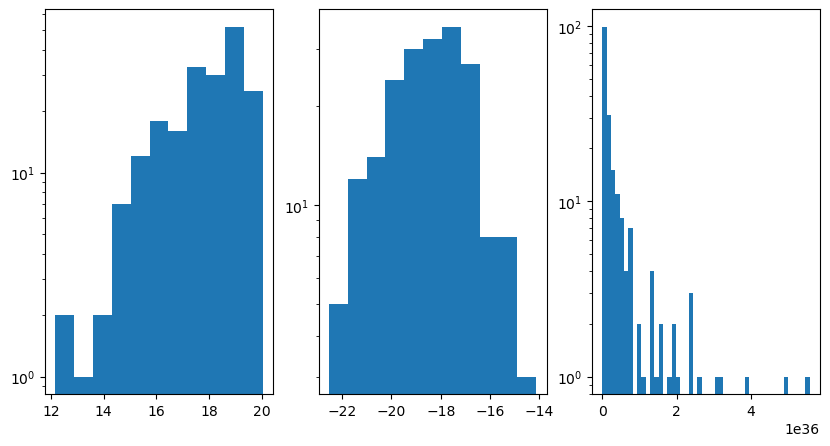

In [227]:
if len(data_f) < 1000000:
    # dauert sonst einfach ewig
    fig, ax = plt.subplots(ncols = 3, figsize=(10,5))

    plot_names = ["APP_MAG_R", "ABS_MAG_R", "LUM_R"]
    cnt = 0
    for axis in ax:
        axis.hist(data_f[plot_names[cnt]], bins = "auto")
        axis.set_yscale("log")
        cnt += 1
    plt.show()

In [228]:
inspect_abs_mags = False

if inspect_abs_mags:
    data_to_inspect = data_f[data_f["ABS_MAG_R"]> -12]
    fig, ax = plt.subplots(ncols = 5, figsize = (15,8))
    
    ax[0].hist(data_to_inspect["ABS_MAG_R"], bins = "auto")
    ax[0].set_xlabel("abs mag in r-band")
    ax[1].hist(data_to_inspect["MW_TRANSMISSION"], bins = "auto")
    ax[1].set_xlabel("MW_TRANSMISSION")
    ax[2].hist(data_to_inspect["APP_MAG_R"], bins = "auto")
    ax[2].set_xlabel("App mag r-band")
    ax[3].hist(data_to_inspect["DIST_Z_MEAN"], bins = "auto")
    ax[3].set_xlabel("distance from redshift")
    ax[4].hist(data_to_inspect["Z"], bins = "auto")
    ax[4].set_xlabel("redshift")
    
    mean_redshift_pec_objects = np.mean(data_to_inspect["Z"])
    mean_distance_pec_objects = np.mean(data_to_inspect["DIST_Z_MEAN"])*u.Mpc
    min_redshift_pec_objects = np.min(data_to_inspect["Z"])
    min_distance_pec_objects = np.min(data_to_inspect["DIST_Z_MEAN"])*u.Mpc
    
    data_to_inspect_len = len(data_to_inspect)
    star_data_len = len(data_to_inspect[data_to_inspect["SPECTYPE"] == "STAR"])
    
    print(f"These objects have a mean redshift of {mean_redshift_pec_objects}, which corresponds to a mean distance of {mean_distance_pec_objects}")
    print(f"The minimum redshift is {min_redshift_pec_objects}, i.e. {min_distance_pec_objects}")
    print(f"According to WolframAlpha the closest galaxy has a distance of roughly 25000ly = 7655pc (not Mpc, simply pc), so any object below 0.07Mpc is definitely not a real galaxy")
    print(f"This reminded me to check if we have selected galaxies only...")
    print(f"We have {star_data_len} stars in our catalogue of peculiar objects, compared to a total number of {data_to_inspect_len} objects...")
                        
    for axis in ax:
        axis.set_ylabel("bin count")
        #axis.legend()
        
    plt.tight_layout()
    plt.show()
    

In [229]:
# np.max(data_f["MW_TRANSMISSION"])

### start calculating the P_Gal (the probability that galaxy X is the host)

In [230]:
max_lum_r = np.max(data_f["LUM_R"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_R"] == max_lum_r]["PROBDENSITY"]
print(f"The maximum luminosity in our catalog in the r-band is {max_lum_r} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our catalog in the r-band is 5.586803133446306e+36 W with a prob density of      PROBDENSITY     
---------------------
0.0006913585861411703


In [231]:
if modeled_search:
    
    dist_delta = abs(data_f["DIST_Z_MEAN"]-data_f["DISTMU"])
    combined_sigma2 =  data_f["DISTSIGMA"]**2 + data_f["DIST_Z_COSMO_SIGMA"].value**2 + data_f["DIST_Z_ERR"]**2
    P_gal_unnorm = data_f["LUM_R"]*data_f["PROBDENSITY"]/(np.sqrt(2*np.pi*combined_sigma2))*np.exp(-dist_delta**2/(combined_sigma2))
    
    P_gal_sum = np.sum(P_gal_unnorm)
    P_gal = 1/P_gal_sum * P_gal_unnorm


else:
    P_gal_unnorm = data_f["LUM_R"]*data_f["PROBDENSITY"]
    P_gal_sum = np.sum(P_gal_unnorm)
    P_gal = 1/P_gal_sum * P_gal_unnorm

### Get the missed fraction of DESI due to mass/luminosity incompleteness

$$f_{missed} =  \frac{\int_{-\infty}^{\infty} dM 10^{-0.4M}\left(1-\frac{Hist}{Schechter}\right)\cdot Schechter}{\int_{-\infty}^{\infty}dM 10^{-0.4M}\cdot Schechter}$$

We want to account for the fact that some region were covered in more detail by DESI than others...

In [232]:
if modeled_search:
    
    # get the Schechter model, see 1/V estimator, bin size of half a mag
    from astropy.modeling.models import Schechter1D

    phi_star = 0.0016745140734036254
    m_star = -21.757361746831197
    alpha = -1.1297780395774693

    schechter_model = Schechter1D(phi_star, m_star, alpha)
    
    data_min_dist = np.min(data_f["DIST_Z_MEAN"])*u.Mpc
    data_max_dist = np.max(data_f["DIST_Z_MEAN"])*u.Mpc
    
    abs_mag_max = np.max(data_f["ABS_MAG_R"])
    abs_mag_min = np.min(data_f["ABS_MAG_R"])

    bins = np.arange(abs_mag_min, abs_mag_max, 0.5)

    hist, bins = np.histogram(data_f["ABS_MAG_R"], bins =  bins)
    """
    # normalize our histogram to our volume
    volume = V_
    hist = hist/(volume)
    
    #hist = hist/(area_99.to_value(u.deg**2)*(data_max_dist-data_min_dist).value*10**0) # completely wrong normalization
    
    print(f"{abs_mag_min}, {abs_mag_max}, {data_min_dist}, {data_max_dist}, {(data_max_dist-data_min_dist).value*10**6}")
    
    fig, ax = plt.subplots(figsize = (5,2.5))
    bins_center = bins[1:]-(bins[1]-bins[2])/2
    ax.plot(bins_center, hist, label = "wrongly normalized distribution")
    ax.plot(np.linspace(-25,-18), schechter_model(np.linspace(-25,-18)),  label = "some schechter fit", color = "red")

    ax.set_yscale("log")
    plt.show()"""

In [233]:
if modeled_search:
    def hist_func(M):
        # https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
        # make sure array is a numpy array
        # array = np.array(array)
        idx = (np.abs(hist - M)).argmin()
        val = hist[idx]
        #print(f"val {val}")
        return val

    def num_func(M):
        #print(f"M is {M}")
        schechter_val = schechter_model(M)
        #print(f"schechter Val: {schechter_val}")
        lum_factor = 10**(-0.4*M)
        #print(f"lum factor {lum_factor}")
        weighting_coverage = (1-hist_func(M)/(schechter_val))
        #print(f"weighting_coverage: {weighting_coverage}")
        final_val = lum_factor*weighting_coverage*schechter_val
        #print(f"final value: {final_val}")
        return final_val
    def denom_func(M):
        lum_factor = 10**(-0.4*M)
        schechter_val = schechter_model(M)
        final_val = lum_factor*schechter_val

        return final_val




    numerator = quad(num_func, -28, -18)
    denominator = quad(denom_func, -28, -18)

    print(numerator)
    print(denominator)

    f_missed = numerator[0]/denominator[0]

    print(f_missed)

(-344119891247.08496, 1200.845593769946)
(877176.5712112696, 0.0017536415515806425)
-392304.01556655695


In [234]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value})])

In [235]:
data_f[:]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R,P_GAL
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633424062875024,111.713566147542,63.1419730649608,20211117,0.0390282946484466,9.9844344587878e-06,0,278.126159667969,718.665405273438,1441.375,GALAXY,514,0.0725817605853081,6.0,385953,0.0007914254560411755,151.82945226251914,58.02227254505086,3.785577524527747e-05,170.85659538718602,0.04246309527603858,15.253727635738004,0.8646191207736298,15.200745240148763,-21.051715408269118,1.4207573975323272e+36,0.033549356753869206
39633426789173308,111.736171284179,63.5552435372105,20211021,0.0282042086536955,9.10882947082062e-07,0,165.932754516602,274.627471923828,363.853668212891,GALAXY,514,0.0634711235761642,1.0,385959,0.0007781040677504851,151.48402115621033,57.97892255525045,3.801383409175562e-05,122.50478954437932,0.003873894075155383,10.864472819035733,0.8805514448793541,16.265026887513567,-19.2649641181716,2.740434396681219e+35,0.005621095486561334
39633426789172888,111.672975853296,63.4535669550102,20211021,0.023791464661012,3.97896035168704e-06,0,10.0822553634644,16.180212020874,20.4424533843994,GALAXY,514,0.0679906606674194,1.0,385958,0.0007746452342657246,151.39231329655962,57.93833465403801,3.806081984646445e-05,103.00379372971504,0.016922160079391273,9.110119380929953,0.8726114935155593,19.329591801926924,-15.823868401245377,1.151810738429326e+34,0.00015245498106018247
39633424058681945,111.307806799194,63.3154698241461,20211021,0.038475792351274,5.51130247206232e-06,0,62.5688514709473,94.1482772827148,98.9482116699219,GALAXY,514,0.0625854134559631,1.0,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,168.37082638333962,0.023439100532889834,15.026721537298805,0.8821159119634253,17.429283195966413,-18.79134907825317,1.7716315018229665e+35,0.004169946344264388
39633424058682535,111.385755808088,63.2784339826973,20211117,0.0383910478884679,2.03680573514479e-06,0,14.6463298797607,21.6853809356689,25.1931324005127,GALAXY,514,0.0652815327048302,0.5,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,167.98971954179018,0.00866233854358257,14.991930866978695,0.8773622696364212,19.01752974589858,-17.198181245078306,4.0841930382704677e+34,0.0009648508359422106
39633424058681927,111.306252346634,63.3144971667035,20211117,0.0384274688566561,2.00844713206849e-06,0,97.4660873413086,147.433029174805,205.112854003906,GALAXY,514,0.0624894313514233,1.42138993740082,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,168.15350388744693,0.008541731946953889,15.006882073865858,0.8822856160370881,16.94253602565678,-19.275291300803836,2.7666249106417043e+35,0.006525625818808566
39633426784979528,111.279991924303,63.4280463971166,20211021,0.0381069720062911,1.95841465161006e-06,0,11.5349740982056,21.9496326446533,34.4434394836426,GALAXY,514,0.0604563802480698,1.0,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,166.71251927142964,0.008328948315176003,14.875362153838385,0.885887893405409,19.014878776175284,-17.18425777926213,4.032151805421024e+34,0.0009638090485777159
39633424058683656,111.521359743308,63.2010567163675,20211021,0.016143982428459,1.24046095033973e-05,0,63.5243835449219,112.67317199707,154.746505737305,GALAXY,514,0.066321074962616,1.59492409229279,385955,0.0007710554010457992,151.4664805554651,57.9604933240595,3.802459392105197e-05,69.49959661159181,0.05275602641495959,6.117729618698196,0.8755362588315873,17.226134038801387,-17.07291612981442,3.6391521595427153e+34,0.0001318585760254894


## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (done above) (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}L_r(1-f_{missed})\cdot P_{2D}\frac{e^{-\frac{\left(D_{LVC}-D_{desi}\right)^2}{\sigma_{D,desi}^2+\sigma_{D,cosmo}^2+\sigma_{D,LVC}^2}}}{\sqrt{2\pi \left(\sigma_{D,desi}^2+\sigma_{D,cosmo}^2+\sigma_{D,LVC}^2\right)}}$$
- others may follow...

Since we have the actual luminosity (here in r-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [236]:
N_galaxies = 20 # how many galaxies we can cover

In [237]:
total_lum = np.sum(data_f["LUM_R"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [238]:
data_sort_by_lums = data_f.group_by("LUM_R")
data_sort_by_lums = data_sort_by_lums[::-1]

In [239]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_R"][:N_galaxies])

In [240]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 4.811390086447225e+37, i.e. 58.54820677037489 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39633424046099433
39633429460946003
39633432132718111
39633440055755334
39633429481914765
39633429460946859
39633429481914934
39633429452556827
39633421277855936
39633434800296858
39633421277858835
39633424033518029
39633440047370893
39633418509619123
39633418526394874
39633424062875024
39633424033515014
39633426772396229
39633424062873866
39633434808682308


### Compare lum with P_Gal ranking

In [241]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_R"][:N_galaxies])
lum_after_10_PGal = np.sum(data_sort_by_PGal["LUM_R"][:10])

In [242]:
print(f"The luminosity we cover when observing {N_galaxies} galaxies ranked by P_gal is {lum_after_N_PGal}W, i.e. {lum_after_N_PGal*100/total_lum}% of the total (DESI) luminosity in the search area")
print(f"The luminosity we cover when observing 10 galaxies ranked by P_gal is {lum_after_10_PGal}W, i.e. {lum_after_10_PGal*100/total_lum}% of the total (DESI) luminosity in the search area") 

print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])


The luminosity we cover when observing 20 galaxies ranked by P_gal is 3.3615447285786455e+37W, i.e. 40.90552050457716% of the total (DESI) luminosity in the search area
The luminosity we cover when observing 10 galaxies ranked by P_gal is 2.288831124131789e+37W, i.e. 27.852025196545547% of the total (DESI) luminosity in the search area
The TARGETID values of these galaxies are: 
    TARGET_RA        TARGET_DEC    ...      TARGETID            P_GAL        
---------------- ---------------- ... ----------------- --------------------
109.679989646446 63.1859641956687 ... 39633424046099433  0.11285691573827052
110.293783220425 63.6778914381844 ... 39633429481914765  0.06961272762817944
110.314138321524 63.6504317896136 ... 39633429481914934 0.054535915563381276
107.976547449392 64.3383699099546 ... 39633434800296858  0.04034513987715156
110.899530203126 62.8054387147274 ... 39633418526394874   0.0368619806336522
 107.61178560693 62.9409343260143 ... 39633421277858835  0.03611415226180546
1

In [243]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:20]

TARGET_RA,TARGET_DEC,SERSIC,TARGETID,P_GAL
float64,float64,float64,int64,float64
109.679989646446,63.1859641956687,3.46704173088074,39633424046099433,0.11285691573827052
110.293783220425,63.6778914381844,2.24766325950623,39633429481914765,0.06961272762817944
110.314138321524,63.6504317896136,4.0,39633429481914934,0.054535915563381276
107.976547449392,64.3383699099546,3.40936183929443,39633434800296858,0.04034513987715156
110.899530203126,62.8054387147274,5.34930229187012,39633418526394874,0.0368619806336522
107.61178560693,62.9409343260143,5.36525583267212,39633421277858835,0.03611415226180546
108.194045155888,63.3413568832094,1.75820446014404,39633424033518029,0.03439268956698137
111.713566147542,63.1419730649608,6.0,39633424062875024,0.033549356753869206
111.560574739366,63.2346973676546,1.91962885856628,39633424062873866,0.03097630893000877


In [244]:
P_Gal_cumsum = np.cumsum(data_sort_by_PGal["P_GAL"])

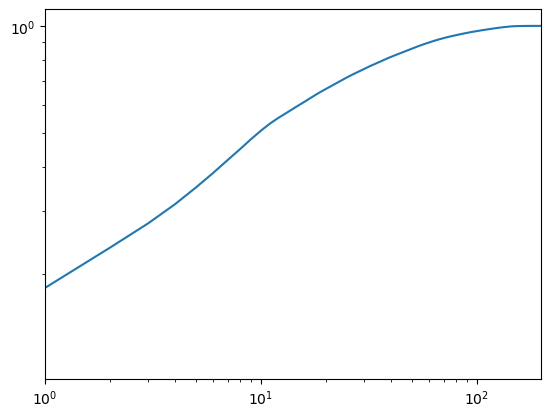

In [245]:
plt.plot(list(range(len(P_Gal_cumsum))),  P_Gal_cumsum)
plt.xscale("log")

plt.yscale("log")
plt.xlim(1,len(P_Gal_cumsum))
plt.savefig(dpi = 100, fname = f"{superevent_name}PGAL_CUMULATIVE099.png")
plt.show()

In [246]:
"""data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_R"][:N_galaxies])"""

'data_sort_by_PGal_C = data_f.group_by("P_GAL_C")\ndata_sort_by_PGal_C = data_sort_by_PGal_C[::-1]\n\nlum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_R"][:N_galaxies])'

In [247]:
"""print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])"""

'print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") \nprint("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])'

## Exclude unobservabe objects from the PGal ranking and export list

We want to cut out galaxies that are not observable by Wendelstein. For this we need the date (to calculate alt and az; we do this for three times to check observability) and Wendelstein location.

In [248]:
# convert DEG:MIN:SEC to deg with decimals...
def conv_to_deg(deg, arcmin, arcsec):
    return (deg+ arcmin/60+ arcsec/3600)*u.deg

### Get the observable objects (i.e. alt > 0) in the next night and apply that selection to our data

In [249]:
# set the timzone
timezone = "Europe/Berlin"
tz_Berlin = pytz.timezone(timezone)

# get the date (and actually time, but that it useless for us) of today and tomorrow
day_Berlin = datetime.now(tz_Berlin)
tmrw_Berlin = day_Berlin + timedelta(hours = 23, minutes = 59, seconds = 59)

# set the Wendelstein location
Wendelstein_loc = EarthLocation(lat = conv_to_deg(47, 42, 13.1), lon = conv_to_deg(12, 0, 43.4), height = 1838*u.m) #check - or + 12

# define the sun object, which will tell us sunrise and set
sun = SunTimes(Wendelstein_loc.lon.to_value(), Wendelstein_loc.lat.to_value(), Wendelstein_loc.height.to_value())
sunset_time = sun.setwhere(day_Berlin, timezone)
sunrise_time = sun.risewhere(tmrw_Berlin, timezone)

# get a time array that includes the sunset time and from there a 30min interval until sunset
t = np.arange(sunset_time, sunrise_time, timedelta(minutes=45)).astype(datetime)              # this may throw a deprecation warning, but seems fine anyway: https://github.com/numpy/numpy/issues/23904

# a little cheap but effective: observation at sunset is useless, start 1h after:
t = t[2:]

/tmp/ipykernel_2090118/3580540673.py:18: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t = np.arange(sunset_time, sunrise_time, timedelta(minutes=45)).astype(datetime)              # this may throw a deprecation warning, but seems fine anyway: https://github.com/numpy/numpy/issues/23904


In [250]:
# get all the SkyCoords for each objects in the data catalog
target_SkyCoord = SkyCoord(data_sort_by_PGal["TARGET_RA"], data_sort_by_PGal["TARGET_DEC"], unit = "deg")

In [251]:
# get Alt for the different times during the night
# t should be an array that consists of a couple of night times, so if *all* of these times don't have a positive alt it will be discarded
target_Alt = [target_SkyCoord.transform_to(AltAz(obstime = time, location = Wendelstein_loc)).alt.value for time in t]

# now turn it into a numpy array
target_Alt = np.array(target_Alt)

# swap the axes so that the first axis is all the different targets and the second then includes the alt per observing time
target_Alt_swapped = np.swapaxes(target_Alt, 0,1)

# now create the selection for each target in the P_Gal catalog
sel = []
for target in target_Alt_swapped:
    sel.append((target > 0).any())
    
# now apply the selection to the dataset
data_sort_by_PGal_observable = data_sort_by_PGal[sel]

In [252]:
print(f"There were {len(data_sort_by_PGal) - len(data_sort_by_PGal_observable)} non-observable objects in the current dataset. \nWe have {len(data_sort_by_PGal_observable)} objects remaining")

There were 0 non-observable objects in the current dataset. 
We have 198 objects remaining


### Export the final list & print some data

In [253]:
print(f"These are the stats for {superevent_name} follow up :")

These are the stats for S230619bg follow up :


In [254]:
data_min_z = np.min(data_sort_by_PGal_observable["Z"])
data_max_z = np.max(data_sort_by_PGal_observable["Z"])
print(f"Localization area: {area_99.to_value(u.deg**2)*u.deg**2} \nRedshift range in data: {data_min_z} to {data_max_z} \ncorresponding lum distance range: {data_min_dist} to {data_max_dist} \nhighest prob location is at RA = {ra.deg*u.deg} and dec = {dec.deg*u.deg} \ntotal No. of objects in desi data is {len(data_sort_by_PGal)}")


Localization area: 10343.45488358242 deg2 
Redshift range in data: 0.0140483036831276 to 0.0727722682952353 
corresponding lum distance range: 60.38323357325109 Mpc to 326.225654260868 Mpc 
highest prob location is at RA = 114.91416309012875 deg and dec = 46.3750811884355 deg 
total No. of objects in desi data is 198


In [255]:
data_sort_by_PGal_observable["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write(f'PGAL/PGAL_{superevent_name}.ecsv', delimiter=',', format='ascii', overwrite = False)


OSError: File PGAL/PGAL_S230619bg.ecsv already exists. If you mean to replace it then use the argument "overwrite=True".

In [ ]:
# add timing data to table, 